In [25]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [26]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [27]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/IIIT-CFW'
X,y = load_data(dirpath)
cfw_data_x=X
cfw_data_y=y

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


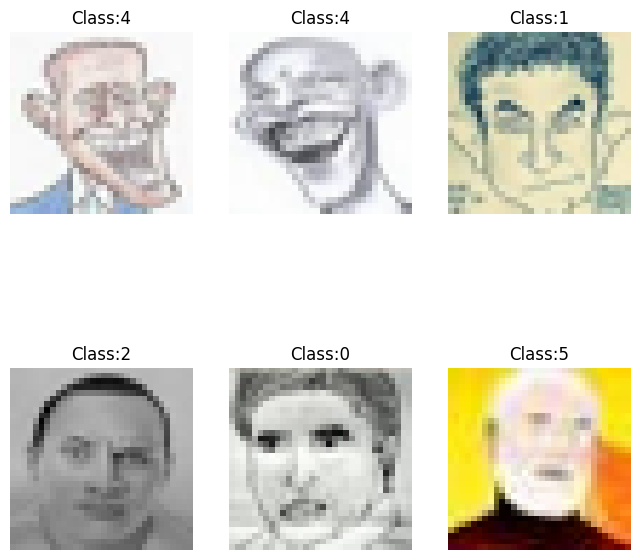

In [28]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

### PCA Class

In [29]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def set_components(self, components):
        self.n_components = components

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_data = X-self.mean
        if not hasattr(self, 'covariance_matrix'):
            self.covariance_matrix = np.cov(centered_data, rowvar=False)
            self.eigenvalues, self.eigenvectors = np.linalg.eig(
                self.covariance_matrix)
            self.eigenpairs = [(self.eigenvalues[i], self.eigenvectors[:, i])
                          for i in range(len(self.eigenvalues))]
            self.eigenpairs.sort(key=lambda x: x[0], reverse=True)
        k = self.n_components
        self.top_eigenpairs = self.eigenpairs[:k]
        top_eigenvectors = np.array([pair[1] for pair in self.top_eigenpairs])
        reduced_data = np.dot(centered_data, top_eigenvectors.T)
        return reduced_data
    
    def reconstruct_image(self,reduced_data):
        top_eigenvectors = np.array([pair[1] for pair in self.top_eigenpairs])
        reconstructed_data=np.dot(reduced_data,top_eigenvectors)+self.mean
        reconstructed_data=reconstructed_data.reshape((672,32,32,3))
        display_images(reconstructed_data[ind,...].real,y[ind], row=2,col=3)

    def cumulative_explained_variance_ratio(self):
        sorted_eigenvalues = sorted(self.eigenvalues.real, reverse=True)
        return np.cumsum(sorted_eigenvalues/np.sum(sorted_eigenvalues))

### PCA on IIIT-CFW dataset

In [44]:
X = cfw_data_x.reshape(672, -1)
print('Original data shape :',X.shape)
print()
components=[100,200,300,400,500,600]
pca = PCA(100)
for comp in components:
    pca.set_components(comp)
    reduced_data = pca.fit(X)
    # print(reduced_data)
    print('Reduced data shape :',reduced_data.shape)
    print('Cumulative explained variance :',pca.cumulative_explained_variance_ratio()[comp-1])
    print()
    # pca.reconstruct_image(reduced_data)

Original data shape : (672, 3072)

Reduced data shape : (672, 100)
Cumulative explained variance : 0.8860128603333124

Reduced data shape : (672, 200)
Cumulative explained variance : 0.94939525766995

Reduced data shape : (672, 300)
Cumulative explained variance : 0.9766740993029741

Reduced data shape : (672, 400)
Cumulative explained variance : 0.9899538257700407

Reduced data shape : (672, 500)
Cumulative explained variance : 0.9964192834424568

Reduced data shape : (672, 600)
Cumulative explained variance : 0.9992898398086215



We see that as we increase the number of components, cumulative explained variance of the data increase

### Plot of Cumulative Explained Variance vs Number of principal components

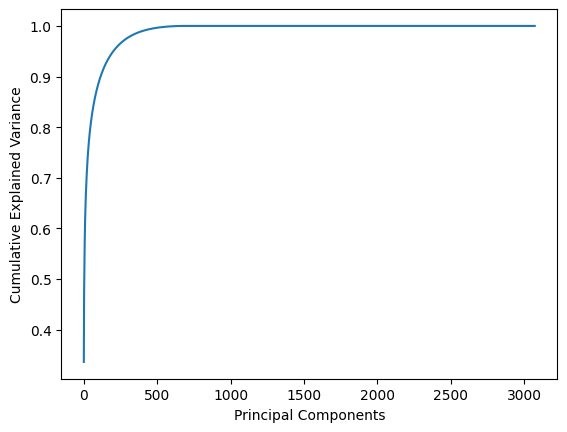

In [31]:
components=np.arange(1,3073)
cumulative_variance=pca.cumulative_explained_variance_ratio()
plt.plot(components,cumulative_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

### PCA on assignment 1 (pictionary dataset)

In [32]:
data = np.load('data.npy', allow_pickle=True)

In [33]:
x = data[:, 2]
y = data[:, 3]
x = [np.squeeze(element, axis=0) for element in x]
x = np.array(x)
print(x.shape)

(1500, 512)


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(
    y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Before PCA:-")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Before PCA:-
Accuracy: 0.21333333333333335
Precision: 0.562315693078851
Recall: 0.21333333333333335
F1_score: 0.4308016553163611


Before PCA:-

| Metric | Value |
|----------|----------|
| Accuracy | 0.21333333333333335 | 
| Precision | 0.562315693078851 | 
| Recall | 0.21333333333333335 | 
| F1 | 0.4308016553163611 | 

In [35]:
pca = PCA(250)
reduced_x = pca.fit(x)
x_train, x_test, y_train, y_test = train_test_split(
    reduced_x, y, test_size=0.2, random_state=42)
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(
    y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("After PCA:-")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

After PCA:-
Accuracy: 0.21666666666666667
Precision: 0.5741741586873166
Recall: 0.21666666666666667
F1_score: 0.4228554310613134


After PCA:-

| Metric | Value |
|----------|----------|
| Accuracy | 0.21666666666666667 | 
| Precision | 0.5741741586873166 | 
| Recall | 0.21666666666666667 | 
| F1 | 0.4228554310613134 | 

### PCA on IIIT-CFW dataset

In [36]:
x = cfw_data_x.reshape(672, -1)
y = cfw_data_y
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2,random_state=42)
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("Before PCA:-")
print("Accuracy:", accuracy)


Before PCA:-
Accuracy: 0.34074074074074073


In [37]:
accuracy_components=[]
pca=PCA(1)
for component in range(1,673):
    pca.set_components(component)
    reduced_x=pca.fit(x)
    x_train, x_test, y_train, y_test = train_test_split(
        reduced_x.real, y, test_size=0.2)
    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_components.append(accuracy)
    # print(component,"Accuracy:", accuracy)

After PCA:-


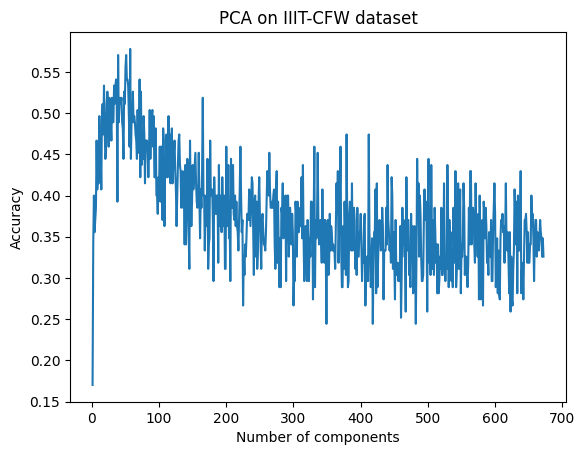

In [38]:
print("After PCA:-")
components=np.arange(1,673)
plt.plot(components,accuracy_components)
plt.title('PCA on IIIT-CFW dataset')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.show()


### PCA on Pictionary Dataset

In [45]:
import pandas as pd

drawer_data=pd.read_csv('drawer_attributes.csv')
guesser_data=pd.read_csv('guesser_attributes.csv')

#### Drawer Dataset

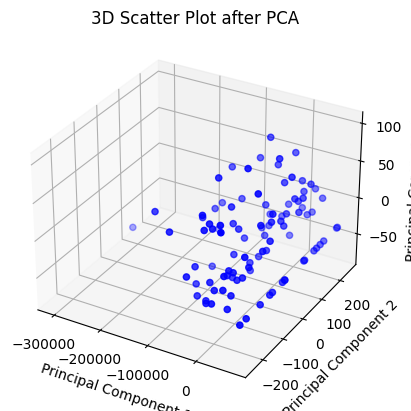

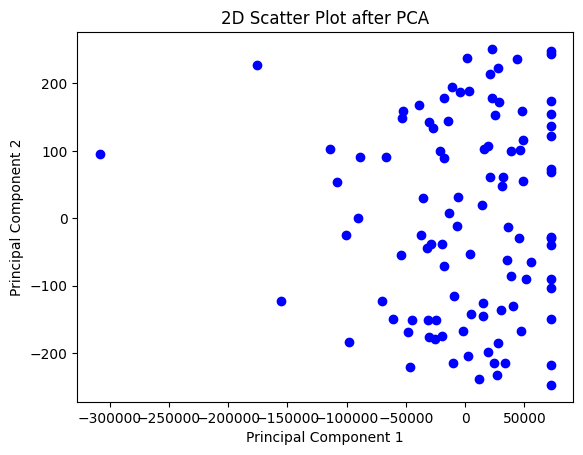

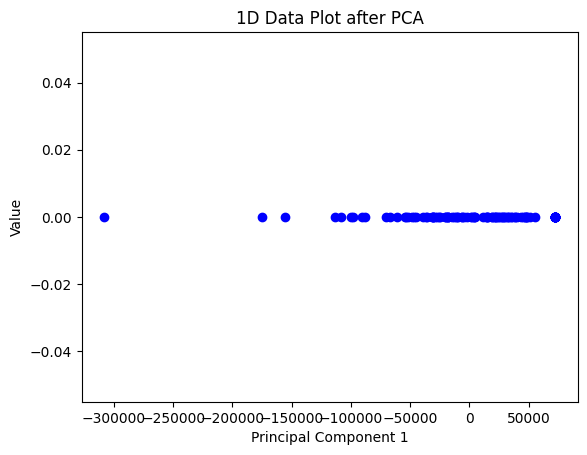

In [46]:
pca=PCA(3)
reduced_data=pca.fit(drawer_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='b', marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Scatter Plot after PCA')
plt.show()
    
pca.set_components(2)
reduced_data=pca.fit(drawer_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='b', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot after PCA')
plt.show()

pca.set_components(1)
reduced_data=pca.fit(drawer_data)
plt.scatter(reduced_data,np.zeros(len(reduced_data)) ,linestyle='-', marker='o', color='b')
plt.xlabel('Principal Component 1')
plt.ylabel('Value')
plt.title('1D Data Plot after PCA')
plt.show()

After PCA, the new axes represent the principal components along which the variance of original data is maximum. Each principal component is orthogonal and uncorrelated to other principal components. The first principal component or PC1 represents the direction in which variance is maximum, PC2 represents the direction in which variance is second highest and so on.

#### Guesser Dataset

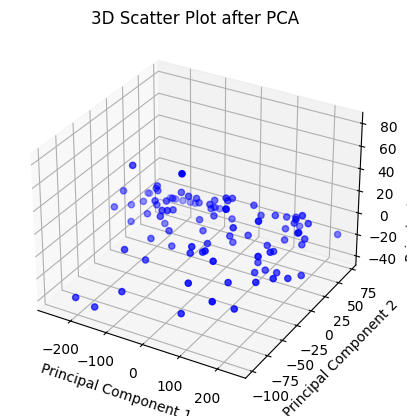

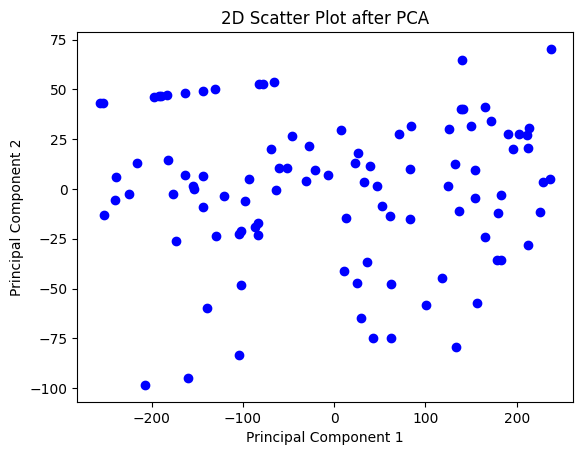

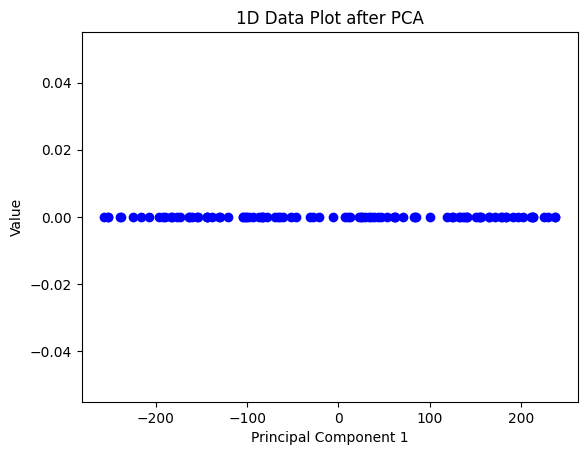

In [47]:
pca=PCA(3)
reduced_data=pca.fit(guesser_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='b', marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Scatter Plot after PCA')
plt.show()

pca.set_components(2)
reduced_data=pca.fit(guesser_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='b', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot after PCA')
plt.show()

pca.set_components(1)
reduced_data=pca.fit(guesser_data)
plt.scatter(reduced_data,np.zeros(len(reduced_data)) ,linestyle='-', marker='o', color='b')
# plt.plot(reduced_data, linestyle='-', marker='o', color='b')
plt.xlabel('Principal Component 1')
plt.ylabel('Value')
plt.title('1D Data Plot after PCA')
plt.show()

After PCA, the new axes represent the principal components along which the variance of original data is maximum. Each principal component is orthogonal and uncorrelated to other principal components. The first principal component or PC1 represents the direction in which variance is maximum, PC2 represents the direction in which variance is second highest and so on.